We’ll settle for an iterative algorithm that usually finds a good clustering:

1. Start with a set of k-means, which are points in d-dimensional space.
2. Assign each point to the mean to which it is closest.
3. If no point’s assignment has changed, stop and keep the clusters.
4. If some point’s assignment has changed, recompute the means and return to step 2.

In [2]:
# import libraries
from linear_algebra import Vector, squared_distance, vector_mean

import itertools
import random
import tqdm

from typing import List, Tuple, NamedTuple, Union, Callable

We’ll create a helper function that measures how many coordinates two vectors differ in.

In [3]:
def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

assert num_differences([1, 2, 3], [2, 1, 3]) == 2
assert num_differences([1, 2], [1, 2]) == 0

Another function that computes the means of the clusters

In [4]:
def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

Ready to code up our clusterer!

In [5]:
class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]
                
                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return
                
                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed : {num_changed} / {len(inputs)}")


### Let’s take a look at how this works

You know the locations of all your local users, and she’d like you to choose meetup locations that make it convenient for everyone to attend.

In [6]:
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
inputs_df = pd.DataFrame(inputs, columns= ["x", "y"])

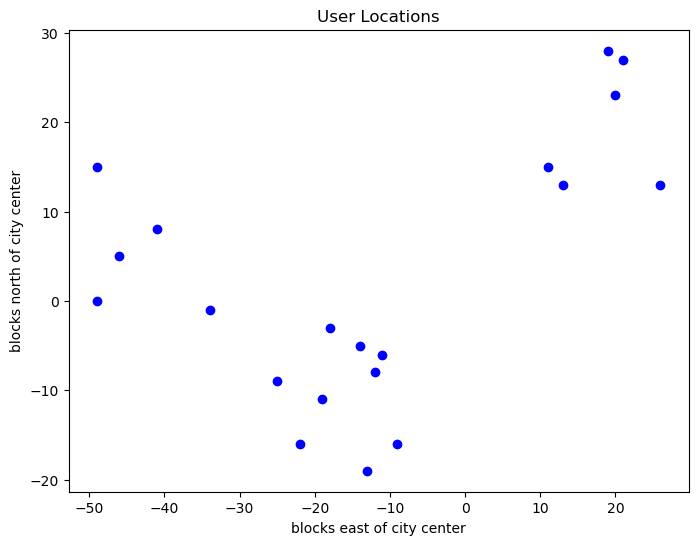

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(inputs_df.x, inputs_df.y, c="blue")
plt.title("User Locations")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

Imagine first that she has enough budget for three meetups.

In [10]:
random.seed(12)                   # so you get the same results as me
clusterer = KMeans(k=3)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 3

# Check that the means are close to what we expect.
assert squared_distance(means[0], [-44, 5]) < 1
assert squared_distance(means[1], [-16, -10]) < 1
assert squared_distance(means[2], [18, 20]) < 1

changed : 5 / 20: : 1it [00:00, 1296.94it/s]


In [11]:
means_df = pd.DataFrame(means, columns=["x", "y"])

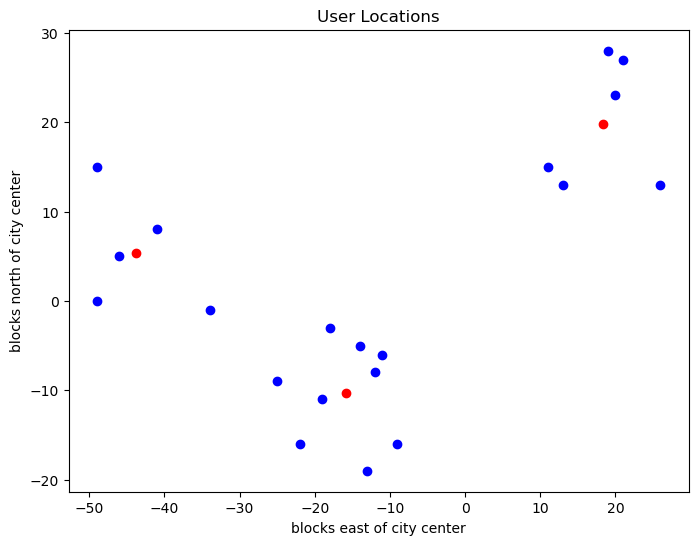

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(inputs_df.x, inputs_df.y, c="blue")
plt.scatter(means_df.x, means_df.y, c="red")
plt.title("User Locations")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

You show your results to the VP, who informs you that now she only has
enough budgeted for two meetups.
“No problem,” you say:

In [13]:
random.seed(0)                   # so you get the same results as me
clusterer = KMeans(k=2)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 2
assert squared_distance(means[0], [-26, -5]) < 1
assert squared_distance(means[1], [18, 20]) < 1

changed : 4 / 20: : 2it [00:00, 1336.40it/s]


In [14]:
means

[[-25.857142857142854, -4.714285714285714],
 [18.333333333333332, 19.833333333333332]]

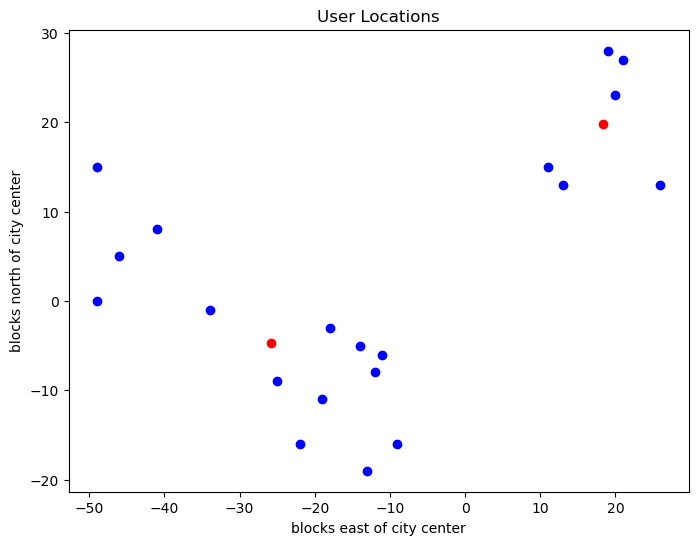

In [15]:
means_df = pd.DataFrame(means, columns=["x", "y"])

plt.figure(figsize=(8, 6))
plt.scatter(inputs_df.x, inputs_df.y, c="blue")
plt.scatter(means_df.x, means_df.y, c="red")
plt.title("User Locations")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

### Choosing K

There are various ways to choose a k. 
One that’s reasonably easy to understand involves plotting the *sum of squared errors* (between each point and the mean of its cluster)

In [16]:
def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

0it [00:00, ?it/s]
changed : 8 / 20: : 1it [00:00, 940.22it/s]
changed : 2 / 20: : 2it [00:00, 1389.99it/s]
changed : 2 / 20: : 2it [00:00, 1319.79it/s]
changed : 2 / 20: : 4it [00:00, 1647.73it/s]
changed : 1 / 20: : 3it [00:00, 1646.12it/s]
changed : 1 / 20: : 5it [00:00, 1285.89it/s]
changed : 4 / 20: : 2it [00:00, 1038.45it/s]
changed : 2 / 20: : 3it [00:00, 1259.55it/s]
changed : 4 / 20: : 3it [00:00, 1096.07it/s]
changed : 1 / 20: : 3it [00:00, 734.51it/s]
changed : 1 / 20: : 3it [00:00, 1286.33it/s]
changed : 1 / 20: : 3it [00:00, 1173.23it/s]
changed : 1 / 20: : 3it [00:00, 904.66it/s]
changed : 1 / 20: : 4it [00:00, 1235.62it/s]
changed : 3 / 20: : 3it [00:00, 1239.57it/s]
changed : 1 / 20: : 4it [00:00, 1059.70it/s]
changed : 3 / 20: : 3it [00:00, 1118.68it/s]
changed : 3 / 20: : 3it [00:00, 1093.60it/s]
changed : 1 / 20: : 5it [00:00, 962.39it/s]


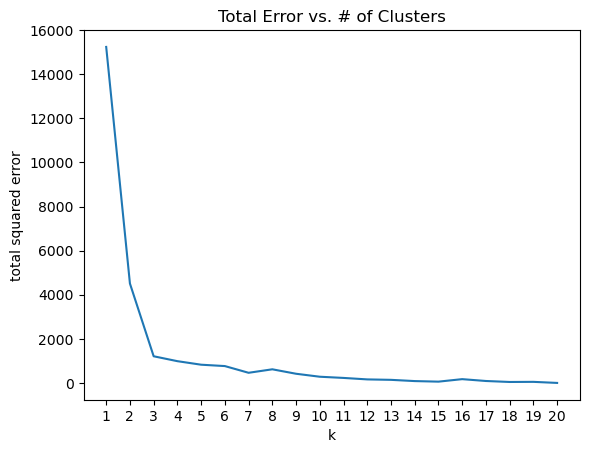

In [17]:
# now plot from 1 up to len(inputs) clusters
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

Looking at figure, this method agrees with our original eyeballing that
three is the “right” number of clusters.

### Example: Clustering colors

The VP of Swag has designed attractive DataSciencester stickers that he’d
like you to hand out at meetups. Unfortunately, your sticker printer can
print at most five colors per sticker. And since the VP of Art is on
sabbatical, the VP of Swag asks if there’s some way you can take his design
and modify it so that it contains only five colors.

Computer images can be represented as two-dimensional arrays of pixels,
where each pixel is itself a three-dimensional vector (red, green, blue)
indicating its color.

Creating a five-color version of the image, then, entails:
1. Choosing five colors.
2. Assigning one of those colors to each pixel.

It turns out this is a great task for k-means clustering, which can partition the pixels into five clusters in red-green-blue space. If we then recolor the pixels in each cluster to the mean color, we’re done.

In [18]:
# install pillow
#pip install pillow

In [19]:
image_path = r"images/girl_with_book.jpeg"    # wherever your image is

import matplotlib.image as mpimg
img = mpimg.imread(image_path) / 256  # rescale to between 0 and 1

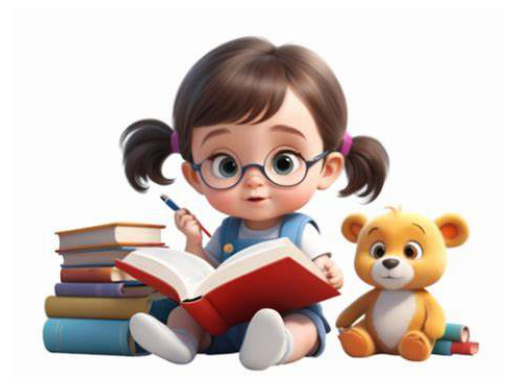

In [20]:
# the original image
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
# we can get a flattened list of all the pixels
# .tolist() converts a numpy array to a Python list
pixels = [pixel.tolist() for row in img for pixel in row]

changed : 1 / 168270: : 50it [00:37,  1.32it/s]    


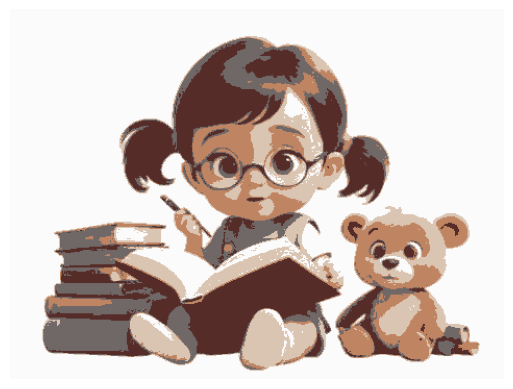

In [22]:
clusterer = KMeans(5)
clusterer.train(pixels)   # this might take a while

#Once it finishes, we just construct a new image with the same format    
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster
    
new_img = [[recolor(pixel) for pixel in row]   # recolor this row of pixels
            for row in img]                     # for each row in the image

# Now, we display it
plt.imshow(new_img)
plt.axis('off')
plt.show()